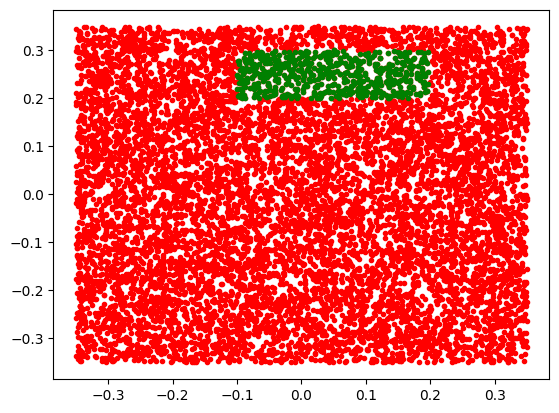

In [1]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #

import numpy as np

import xobjects as xo
import xtrack as xt

import ducktrack as dtk

context = xo.ContextCpu()

x_aper_min = -0.1
x_aper_max = 0.2
y_aper_min = 0.2
y_aper_max = 0.3

part_gen_range = 0.35
n_part=10000

test_part = dtk.TestParticles(
        p0c=6500e9,
        x=np.random.uniform(-part_gen_range, part_gen_range, n_part),
        px = np.zeros(n_part),
        y=np.random.uniform(-part_gen_range, part_gen_range, n_part),
        py = np.zeros(n_part),
        )

particles = xt.Particles.from_dict(test_part.to_dict(), _context=context)

aper_test = dtk.elements.LimitRect(min_x=x_aper_min,
                                          max_x=x_aper_max,
                                          min_y=y_aper_min,
                                          max_y=y_aper_max)

aper = xt.LimitRect(_context=context,
                    **aper_test.to_dict())
aper.track(particles)

aper_test.track(test_part)

part_id = context.nparray_from_context_array(particles.particle_id)
part_state = context.nparray_from_context_array(particles.state)
part_x = context.nparray_from_context_array(particles.x)
part_y = context.nparray_from_context_array(particles.y)

id_alive = part_id[part_state>0]

assert np.allclose(test_part.particle_id, np.sort(id_alive))

import matplotlib.pyplot as plt
plt.close('all')
plt.figure(1)
plt.plot(part_x, part_y, '.', color='red')
plt.plot(part_x[part_state>0], part_y[part_state>0], '.', color='green')

plt.show()


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.03  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2024.04.25               +
  + Execution date: 2024.11.14 15:29:44      +
  ++++++++++++++++++++++++++++++++++++++++++++
enter Twiss module
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:     0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
                 1                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
             0.125                  0                  2                  0 

             dxrms             xcomax             xcorms                 q2 
                 0         

Converting sequence "ss":   0%|          | 0/16 [00:00<?, ?it/s]

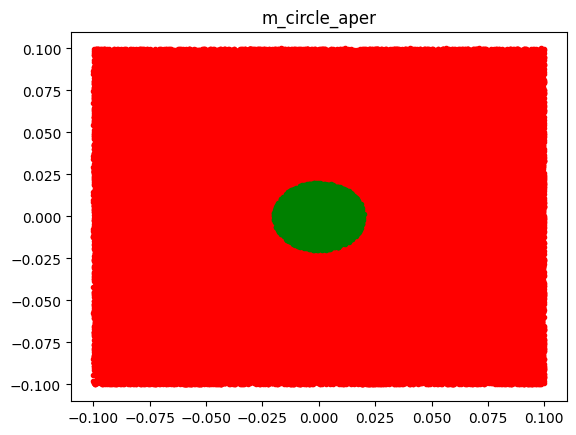

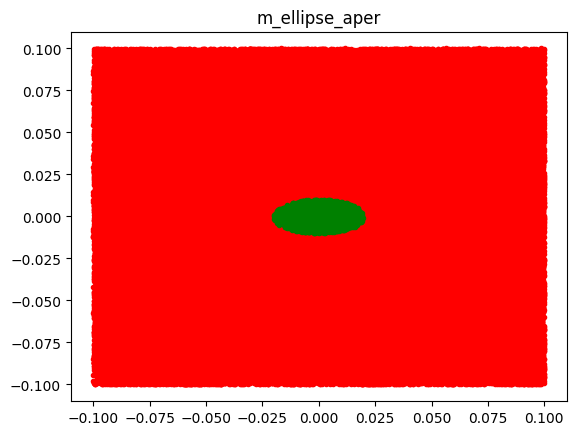

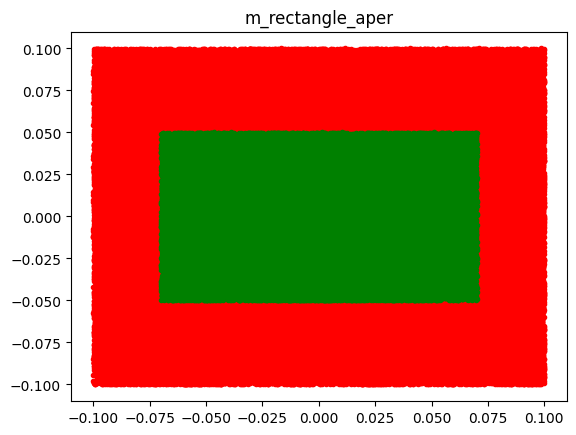

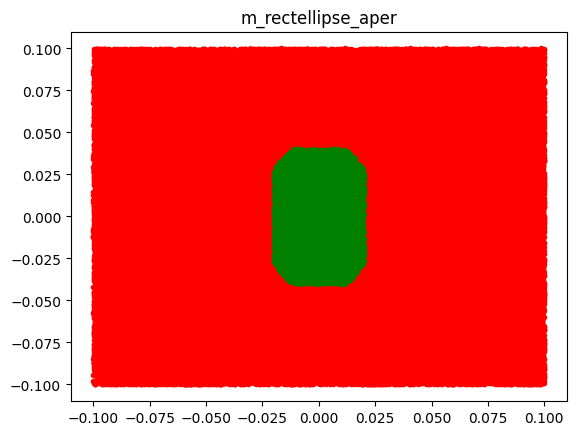

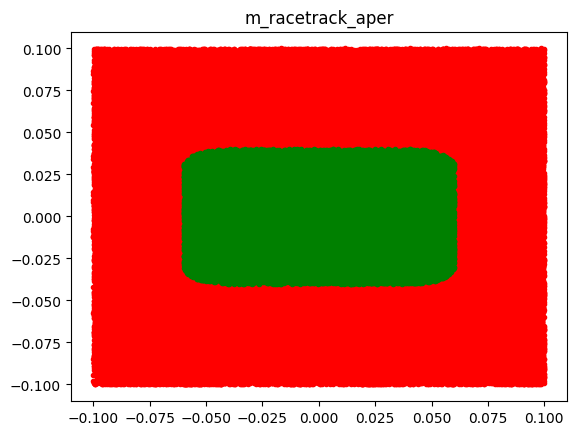

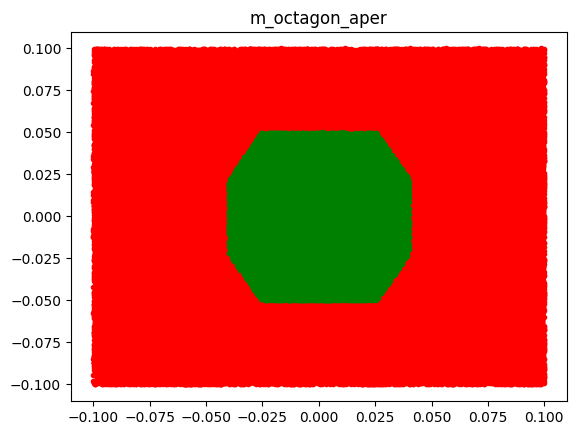

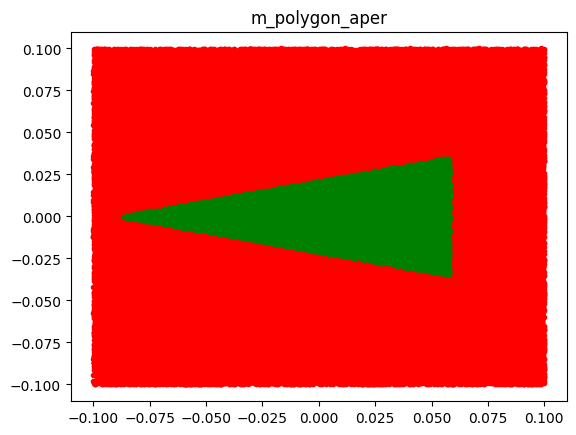

In [3]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #

from cpymad.madx import Madx
import xtrack as xt

import numpy as np

mad = Madx()

mad.input("""
    m_circle: marker, apertype="circle", aperture={.02};
    m_ellipse: marker, apertype="ellipse", aperture={.02, .01};
    m_rectangle: marker, apertype="rectangle", aperture={.07, .05};
    m_rectellipse: marker, apertype="rectellipse", aperture={.02, .04, .025, .045};
    m_racetrack: marker, apertype="racetrack", aperture={.06,.04,.02,.01};
    m_octagon: marker, apertype="octagon", aperture={.04, .05, 0.5, 1.1};
    m_polygon: marker, apertype="circle", aper_vx= {+5.800e-2,+5.800e-2,-8.800e-2}, aper_vy= {+3.500e-2,-3.500e-2,+0.000e+0};

    beam;
    ss: sequence,l=1;
        m_circle, at=0;
        m_ellipse, at=0.01;
        m_rectangle, at=0.02;
        m_rectellipse, at=0.03;
        m_racetrack, at=0.04;
        m_octagon, at=0.05;
        m_polygon, at=0.06;
    endsequence;

    use,sequence=ss;
    twiss,betx=1,bety=1;
    """
    )

line = xt.Line.from_madx_sequence(mad.sequence.ss, install_apertures=True)


part_gen_range = 0.1
n_part=100000
part = xt.Particles(
        p0c=6500e9,
        x=np.random.uniform(-part_gen_range, part_gen_range, n_part),
        px = np.zeros(n_part),
        y=np.random.uniform(-part_gen_range, part_gen_range, n_part),
        py = np.zeros(n_part),
        )

import matplotlib.pyplot as plt
plt.close('all')
i_plot = 1
for ee, nn in zip(line.elements, line.element_names):
    if ee.__class__.__name__.startswith('Limit'):
        part.state[:] = 1
        ee.track(part)

        plt.figure(i_plot)
        plt.plot(part.x[part.state<=0], part.y[part.state<=0], '.', color='red')
        plt.plot(part.x[part.state>0], part.y[part.state>0], '.', color='green')

        plt.title(nn)

        i_plot += 1

plt.show()

In [5]:
line.get_table()

Table: 24 rows, 7 cols
name                  s element_type     isthick isreplica parent_name iscollective
ss$start              0 Marker             False     False None               False
m_circle_aper         0 LimitEllipse       False     False None               False
m_circle              0 Marker             False     False None               False
drift_0               0 Drift               True     False None               False
m_ellipse_aper     0.01 LimitEllipse       False     False None               False
m_ellipse          0.01 Marker             False     False None               False
drift_1            0.01 Drift               True     False None               False
m_rectangle_aper   0.02 LimitRect          False     False None               False
m_rectangle        0.02 Marker             False     False None               False
drift_2            0.02 Drift               True     False None               False
m_rectellipse_aper 0.03 LimitRectEllipse   False     